# Plot for Lucy 6/9/18

Challenge:

Make figures 7-12 of paper https://www.overleaf.com/15154648wznpkvkvxtzn

Provided galaxies:

file name | rotation | pixel size
-|-|-
agc4109natural_kmh20kms.edit4_mom0.fits | 82.83 | 1.7
9244_CLN_V2_0.edit3_mom0.fits | 39.01 | 2
agc6871all_natural_kmh20kms.edit3_mom0.fits | 33.74 | 1.4
9362_CLN_V2_4.edit1_mom0.fits | 64.5 | 2
8408_CLN_V2_0.edit1_mom0.fits | -37.45 | 2
B10_ALL_NAT.APCLN.edit6_mom0.fits | 40.42 | 1.7

Credit to Lucy Newnham for the original code, which I have modified.


Setting up our environment:

In [52]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import interpolation as ipt

In [72]:
df = pd.DataFrame.from_dict({
    'file name': [
        'agc4109natural_kmh20kms.edit4_mom0.fits',
        '9244_CLN_V2_0.edit3_mom0.fits',
        'agc6871all_natural_kmh20kms.edit3smo_mom0.fits',
        '9362_CLN_V2_4.edit1_mom0.fits',
        '8408_CLN_V2_0.edit1_mom0.fits',
        'B10_ALL_NAT.APCLN.edit6_mom0.fits',
    ],
    'rotation': [i-90 for i in [82.83, 39.01, 33.74, 64.5, -37.45, 40.42]],
    'pixel size': [1.7, 2, 1.4, 2, 2, 1.7],
    'bar length': [15.0, 15.8, 13.4, 18.2, 10.4, 9.6],
    'beam major': [8.93745, 7.7544, 5.89444, 7.28172, 9.61848, 10.8678],
    'beam minor': [5.09657, 5.27256, 4.7826, 4.8024, 4.7592, 5.08985],
    'beam pa': [-56.1455, 69.09, -32.4369, 62.98, 80.73, -56.165],
    'ra': [119.0693, 216.53495, 178.44321, 218.32296, 200.7516, 185.00551],
    'dec': [11.66217, 5.23793, 10.40315, 3.9034, 13.95065, 8.60778],
})
df

,file name,rotation,pixel size,bar length,beam major,beam minor,beam pa,ra,dec
0,agc4109natural_kmh20kms.edit4_mom0.fits,-7.17,1.7,15.0,8.93745,5.09657,-56.1455,119.06930,11.66217
1,9244_CLN_V2_0.edit3_mom0.fits,-50.99,2.0,15.8,7.75440,5.27256,69.0900,216.53495,5.23793
2,agc6871all_natural_kmh20kms.edit3smo_mom0.fits,-56.26,1.4,13.4,5.89444,4.78260,-32.4369,178.44321,10.40315
3,9362_CLN_V2_4.edit1_mom0.fits,-25.50,2.0,18.2,7.28172,4.80240,62.9800,218.32296,3.90340
4,8408_CLN_V2_0.edit1_mom0.fits,-127.45,2.0,10.4,9.61848,4.75920,80.7300,200.75160,13.95065
5,B10_ALL_NAT.APCLN.edit6_mom0.fits,-49.58,1.7,9.6,10.86780,5.08985,-56.1650,185.00551,8.60778


Set the font size

In [54]:
matplotlib.rcParams.update({'font.size': 8})

Define a function which generates all the data we need for a particular galaxy

In [55]:
def makeGalaxyObject(galaxy):
    # Open the FITS file
    hIFits = fits.open(galaxy['file name'])
    data = hIFits[0].data
    
    # Create a WCS object
    w = WCS(galaxy['file name'], naxis=2)

    center = w.all_world2pix([[galaxy['ra'], galaxy['dec']]], 0)[0]

    # Find the offset of the center point of the galaxy from that of the image in pixel coordinates
    offset = center - np.array(data.shape) / 2
    
    # Make use of scipy to rotate the array about its center
    hIRotated = ipt.rotate(data, galaxy['rotation'])

    # define a rotation matrix
    rotationMatrix = [
        [np.cos(np.deg2rad(galaxy['rotation'])), -np.sin(np.deg2rad(galaxy['rotation']))],
        [np.sin(np.deg2rad(galaxy['rotation'])), np.cos(np.deg2rad(galaxy['rotation']))]
    ]

    # Find the center of the galaxy in the new array (pixel coordinates)
    rotatedOffset = np.dot(rotationMatrix, offset)
    rotatedCenter = np.array(hIRotated.shape) / 2 
    rotatedCenter += rotatedOffset

    # Calculate our array of summed values of the center cutout (row then column)
    barRegion = hIRotated[int(rotatedCenter[1]-1):int(rotatedCenter[1]+2), :].T
    middle = np.add.reduce(
        barRegion,
        axis=1
    )
    return {
        'file name': galaxy['file name'],
        'pixel size': galaxy['pixel size'],
        'rotation': galaxy['rotation'],
        'rotation matrix': rotationMatrix,
        'hIFits': hIFits,
        'hIRotated': hIRotated,
        'center': center,
        'rotatedCenter': rotatedCenter,
        'middle': middle,
        'bar length': galaxy['bar length'] / galaxy['pixel size'],
        'beam major': galaxy['beam major'] / galaxy['pixel size'],
        'beam minor': galaxy['beam minor'] / galaxy['pixel size'],
        'beam pa': galaxy['beam pa'],
    }

In [56]:
galaxy = df.iloc[0]
hIFits = fits.open(galaxy['file name'])
data = hIFits[0].data
w = WCS(galaxy['file name'], naxis=2)
w.wcs.cdelt

array([-0.00047222,  0.00047222])

Add a function to generate the rectangles needed for the HI plot

In [57]:
def genBarRectangle(galaxy, rotationMatrix):
    # create rectangles showing the bar size and rotation
    rectangleOrigin = np.array([0, galaxy['center'][1]-1.5])
    barOrigin = np.array([-galaxy['bar length']/2, -1.5])
    return (
        Rectangle(
            np.dot(
                galaxy['rotation matrix'], 
                rectangleOrigin - galaxy['center']
            ) + galaxy['center'],
            galaxy['hIRotated'].shape[1],
            3,
            alpha=0.8,
            angle=galaxy['rotation']
        ),
        Rectangle(
            np.dot(
                rotationMatrix, 
                barOrigin
            ) + galaxy['center'],
            galaxy['bar length'],
            3,
            alpha=0.8,
            angle=galaxy['rotation'],
            facecolor='w',
        ),
    )

Add a function which returns the beam ellipse, given a galaxy and a position

In [58]:
def genBeamEllipse(g, center=None):
    return Ellipse(
        xy=center if center is not None else [g['beam major'] * 1.1] * 2,
        width=g['beam major'],
        height=g['beam minor'],
        angle=90 + g['beam pa'],
        edgecolor='w',
        facecolor='none',
    )

Define the function which plots an HI overlay, given a galaxy and an m (cropping) value

In [70]:
def makeHIOverlay(galaxy, m, shouldShowBar=True, ticksize=50, beamPosition=[10, 10]):
    n = m * 1.7 / galaxy['pixel size']
    lowerCrop = (galaxy['center'] - n).astype(int)
    upperCrop = (galaxy['center'] + n).astype(int)

    rotatedLowerCrop = (galaxy['rotatedCenter'] - n).astype(int)
    rotatedUpperCrop = (galaxy['rotatedCenter'] + n).astype(int)

    ax = plt.gca()

    # show the HI data
    im = plt.imshow(
        galaxy['hIFits'][0].data,
        origin='lower',
        cmap='inferno'
    )

    # Add rectangles to represent center region and bar size, in the correct orientation
    if shouldShowBar:
        list(map(ax.add_artist, genBarRectangle(galaxy, galaxy['rotation matrix'])))

    # add the beam
    ax.add_artist(
        genBeamEllipse(galaxy, center=lowerCrop + beamPosition)
    )
    
    # Choose the x-ticks we want to display (every 50 arcseconds)
    xticks = np.arange(-500, 500, ticksize)
    # figure out where they should be positioned and place them
    ax.set_xticks(xticks / galaxy['pixel size'] + galaxy['center'][0])
    # set the labels
    ax.set_xticklabels(xticks)

    # same as above for y-axis
    yticks = np.arange(-500, 500, ticksize)
    ax.set_yticks(yticks / galaxy['pixel size'] + galaxy['center'][1])
    ax.set_yticklabels(yticks)

    # axis labels
    ax.set_xlabel('Arcseconds from centre')
    ax.set_ylabel('Arcseconds from centre')

    # setting limits to crop our image
    ax.set_xlim(lowerCrop[0], upperCrop[0])
    ax.set_ylim(lowerCrop[1], upperCrop[1])

    # adjust the positioning so we can fit the colorbar in
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.5)

    # add the colorbar axes
    cbar = plt.colorbar()
    cbar.set_label('Intensity [JY.Hz]')


Define the function which plots the cross section, given a galaxy and an m (cropping) value

In [60]:
def makeCrossSection(galaxy, m):
    n = m * 1.7 / galaxy['pixel size']
    # Choose the cropping we want
    lowerCrop = (galaxy['center'] - n).astype(int)
    upperCrop = (galaxy['center'] + n).astype(int)

    rotatedLowerCrop = (galaxy['rotatedCenter'] - n).astype(int)
    rotatedUpperCrop = (galaxy['rotatedCenter'] + n).astype(int)
    
    ax = plt.gca()
    
    ax.add_line(Line2D(
        [galaxy['rotatedCenter'][1]] * 2, [0, 100000],
        linestyle='--',
        c='k',
    ))
    
    # add a line denoting bar size
    barPosition = np.array([galaxy['bar length']]*2) * [-0.5, 0.5] + galaxy['rotatedCenter'][1]
    bar = Rectangle(
        [barPosition[0], 0],
        galaxy['bar length'],
        10000,
        facecolor='k',
        alpha=0.1,
    )
    ax.add_artist(bar)

    # Plot the array we've calculated
    ax.plot(galaxy['middle'])
    
    # Set the xticks
    xticks = np.arange(-500, 500, 50)
    ax.set_xticks(xticks / galaxy['pixel size'] + galaxy['rotatedCenter'][1])
    ax.set_xticklabels(xticks)

    # Set the limit
    yticks = np.arange(-500, 500, 50)
    ax.set_xlim(rotatedLowerCrop[1], rotatedUpperCrop[1])
    ax.set_ylim(0, np.max(galaxy['middle'])*1.1)

    # And axis label!
    ax.set_ylabel('Intensity [JY.Hz]')
    ax.set_xlabel('Arcseconds from centre')


And run on all galaxies to generate an A4 plot!

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

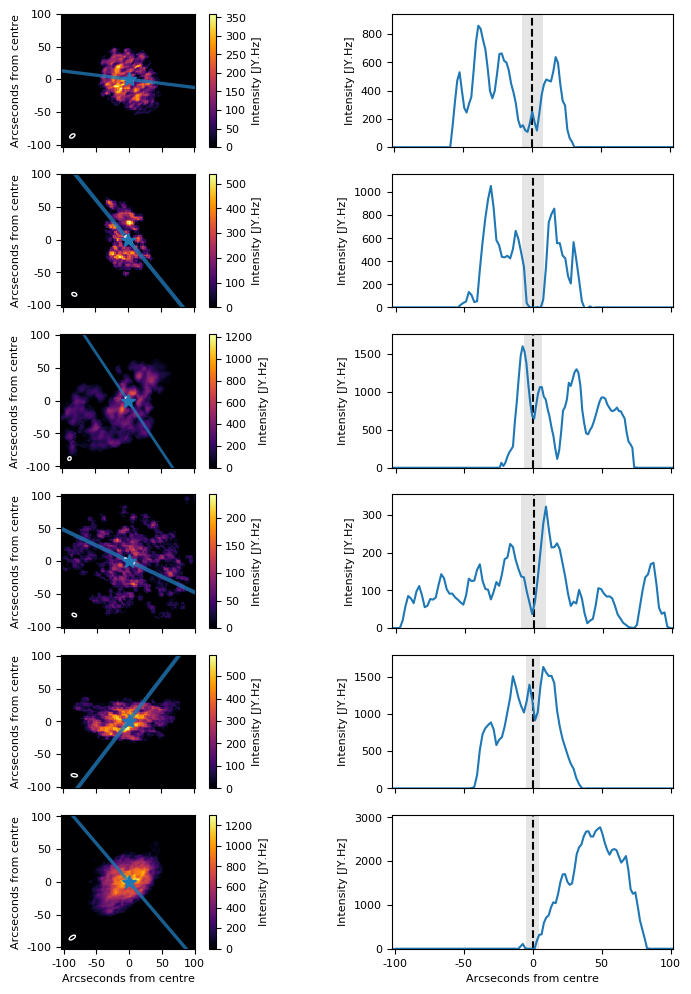

In [73]:
fig = plt.figure(figsize=(8.27, 11.69), dpi=100)
m = 60
for rowIndex in range(len(df)):
    galaxy = makeGalaxyObject(df.iloc[rowIndex])

    # working on the first panel
    plt.subplot(len(df), 2, rowIndex*2 + 1)
    makeHIOverlay(galaxy, m)
    if not rowIndex == len(df) - 1:
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.xlabel('')

    # Now for the second panel
    plt.subplot(len(df), 2, rowIndex*2 + 2)
    makeCrossSection(galaxy, m)
    if not rowIndex == len(df) - 1:
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.xlabel('')

# Save the output
plt.savefig('cross_sections_perpendicular.png', bbox_inches='tight')

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

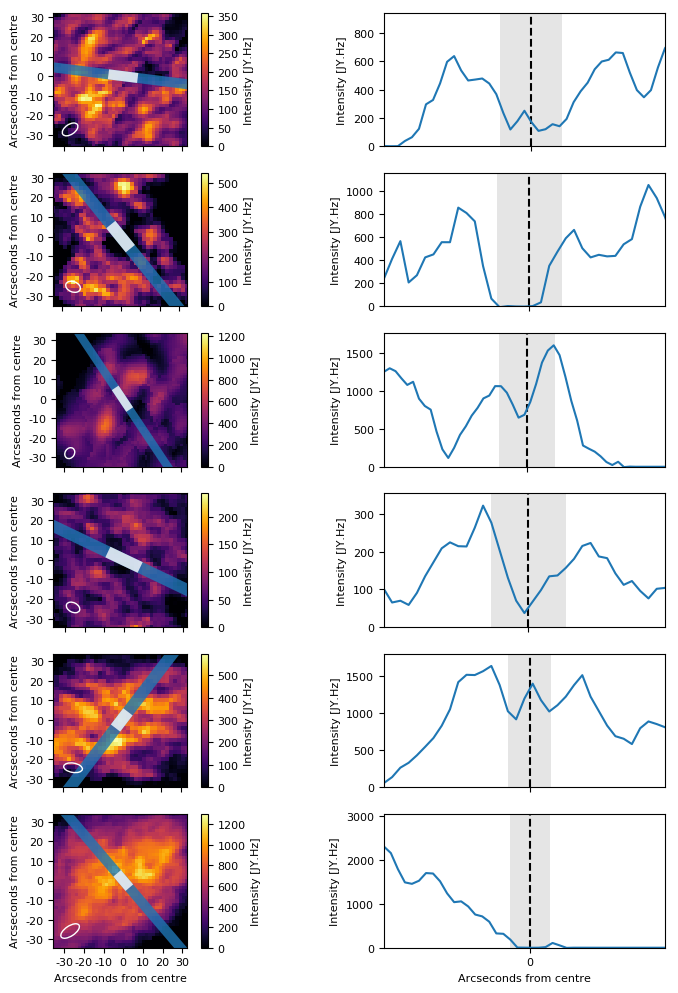

In [62]:
fig = plt.figure(figsize=(8.27, 11.69), dpi=100)
m = 20
for rowIndex in range(len(df)):
    galaxy = makeGalaxyObject(df.iloc[rowIndex])

    # working on the first panel
    plt.subplot(len(df), 2, rowIndex*2 + 1)
    makeHIOverlay(galaxy, m, ticksize=10, beamPosition=[5, 5])
    if not rowIndex == len(df) - 1:
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.xlabel('')

    # Now for the second panel
    plt.subplot(len(df), 2, rowIndex*2 + 2)
    makeCrossSection(galaxy, m)
    if not rowIndex == len(df) - 1:
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.xlabel('')

# Save the output
plt.savefig('cross_sections_zoomed_perpendicular.png', bbox_inches='tight')

We also generate a smaller plot of just the HI intensities:

In [63]:
for shouldShowBar in (False, True):
    fig = plt.figure(figsize=(8.1*0.8, 9*0.8), dpi=100)
    m = 60
    for index in range(len(df)):
        galaxy = makeGalaxyObject(df.iloc[index])
        plt.subplot(int(len(df)/2), 2, index + 1)
        makeHIOverlay(galaxy, m, shouldShowBar)

        # clean up axis labels
        ax = plt.gca()
        if index < len(df) -2:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xlabel('')

        if not index % 2 == 0:
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.set_ylabel('')

        plt.subplots_adjust(
            left=0.0, right=1.0,
            bottom=0.0, top=1.0,
            wspace=0.05, hspace=0.1
        )
    # Save the output
    plt.savefig(
        'HI_intensities{}_perpendicular.png'.format('_bar' if shouldShowBar else ''),
        bbox_inches='tight'
    )
    plt.close()

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

In [64]:
for shouldShowBar in (False, True):
    fig = plt.figure(figsize=(8.1*0.8, 9*0.8), dpi=100)
    m = 20
    for index in range(len(df)):
        galaxy = makeGalaxyObject(df.iloc[index])
        plt.subplot(int(len(df)/2), 2, index + 1)
        makeHIOverlay(galaxy, m, shouldShowBar, ticksize=10, beamPosition=[5, 5])

        # clean up axis labels
        ax = plt.gca()
        if index < len(df) -2:
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xlabel('')

        if not index % 2 == 0:
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.set_ylabel('')

        plt.subplots_adjust(
            left=0.0, right=1.0,
            bottom=0.0, top=1.0,
            wspace=0.05, hspace=0.1
        )
    # Save the output
    plt.savefig(
        'HI_intensities{}_zoomed_perpendicular.png'.format('_bar' if shouldShowBar else ''),
        bbox_inches='tight'
    )
    plt.close()

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

(-0.5, 708.5, 777.5, -0.5)

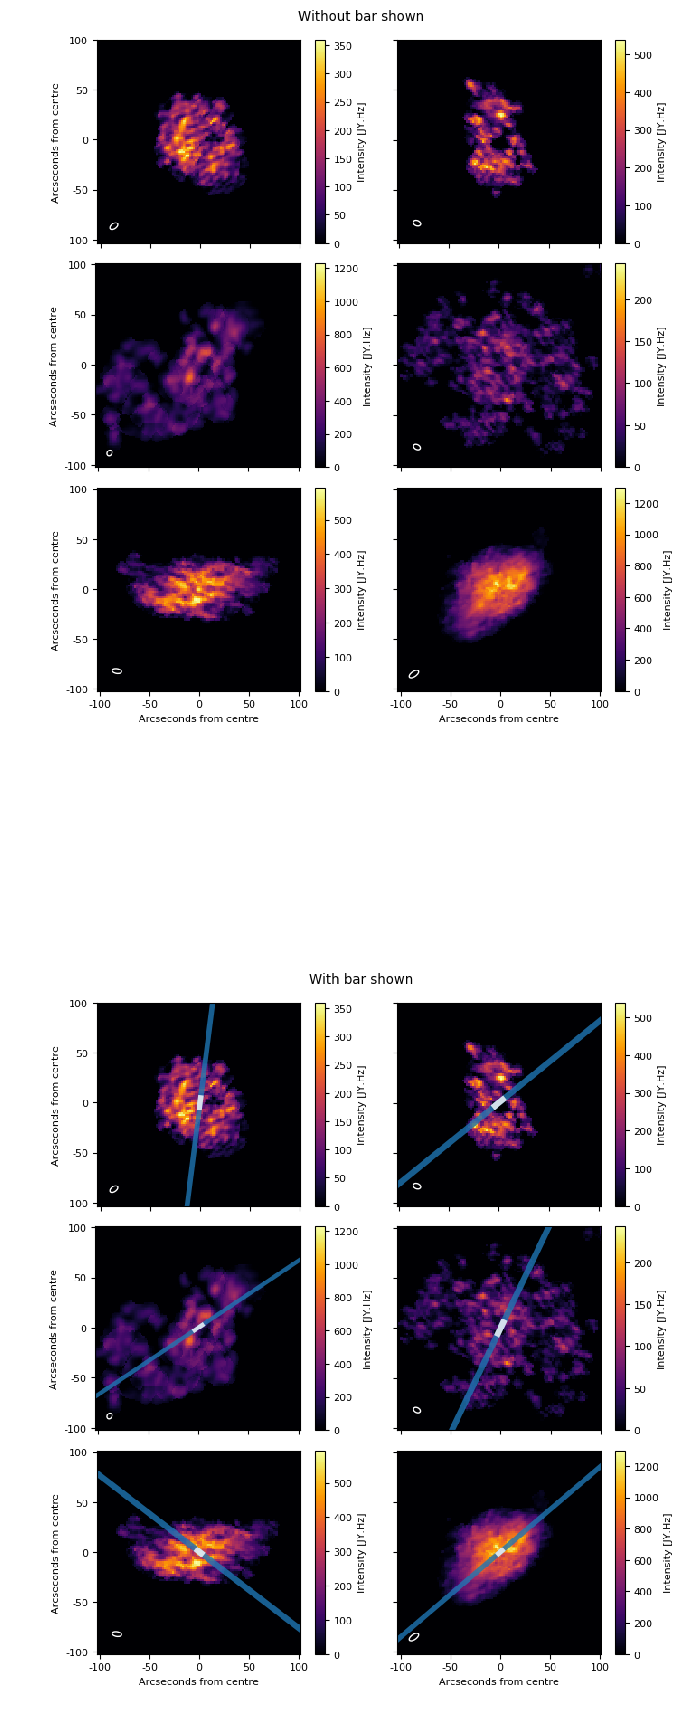

In [65]:
img = mpimg.imread(
    'HI_intensities.png'.format('_bar' if shouldShowBar else '')
)
img_bar = mpimg.imread(
    'HI_intensities_bar.png'.format('_bar' if shouldShowBar else '')
)
fig = plt.figure(figsize=(8.27, 11.69*2), dpi=100)

plt.subplot(211)
plt.title('Without bar shown')
plt.imshow(img)
plt.axis('off')
plt.subplot(212)
plt.title('With bar shown')
plt.imshow(img_bar)
plt.axis('off')